In [13]:
import json
import os
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cycler import cycler
from IPython.display import display
from qsprpred.data import MoleculeTable
from qsprpred.data.descriptors.sets import RDKitDescs
from scipy.stats import kurtosis, skew

a2arcolors = ["#FFCEAD", "#AAC5AC", "#447464", "#575463", "#9E949D", "#C46D5E", "#F4AC32"]

mpl.rcParams['axes.prop_cycle'] = cycler(color=a2arcolors)
sns.set_palette(a2arcolors)

display(sns.color_palette(a2arcolors))

mpl.rcParams.update({'font.size': 15})
COLOR = '#5A5766'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR

[(1.0, 0.807843137254902, 0.6784313725490196),
 (0.6666666666666666, 0.7725490196078432, 0.6745098039215687),
 (0.26666666666666666, 0.4549019607843137, 0.39215686274509803),
 (0.3411764705882353, 0.32941176470588235, 0.38823529411764707),
 (0.6196078431372549, 0.5803921568627451, 0.615686274509804),
 (0.7686274509803922, 0.42745098039215684, 0.3686274509803922),
 (0.9568627450980393, 0.6745098039215687, 0.19607843137254902)]

In [14]:
config_file = "../config.json"
with open(config_file, "r") as f:
    config = json.load(f)

LOMBARDO_DATA = join(config["BASE_DIR"], config["RAW_DATA_DIR"], "Supplemental_82966_revised_corrected.xlsx")
PK_DATA_DIR = join(config["BASE_DIR"], config["PROCESSED_DATA_DIR"], "PKDataset")
PK_FIGURES_DIR = join(config["BASE_DIR"], config["FIGURES_DIR"], "PKDataset")
os.makedirs(PK_FIGURES_DIR, exist_ok=True)

df = pd.read_csv(join(PK_DATA_DIR, "pk_dataset.tsv"), sep="\t")
df.head()

,SMILES,Name,SMILES_withStereo,VDSS,CL,FU,VDSS_raw,CL_raw,FU_raw
0,C#CC1(O)C(CO)OC(n2ccc(N)nc2=O)C1O,TAS-106,C#C[C@@]1(O)[C@@H](CO)O[C@H](n2ccc(N)nc2=O)[C@...,1.10,1.60,NaN,1.1,1.6,NaN
1,C#CC1(O)C=CC2C3CCC4=CC(=O)CCC4C3CCC21CC,Gestodene,C#C[C@]1(O)C=C[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]...,0.46,0.80,0.023,0.46,0.8,0.023
2,C#CC1(O)CCC2C3CCC4=CC(=O)CCC4C3C(=C)CC21CC,Etonogestrel,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4...,2.87,2.00,0.020,2.87,2.0,0.02
3,C#CC1(O)CCC2C3CCC4=CC(=O)CCC4C3CCC21CC,Levonorgestrel,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@@H]4...,1.50,1.80,0.025,1.5,1.8,0.025
4,C#CC1(O)CCC2C3CCC4=Cc5oncc5CC4(C)C3CCC21C,Danazol,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(...,5.18,15.71,NaN,5.18,15.71,NaN


# Data distribution
Create plots of different transformed data distribution for VDSS, CL and FU in the Lombardo et al.
'PKDataset_Distribution_only_log_sqrt.png': Supplementary Figure S2 - Transformations used in the manuscript.

In [10]:
def plot_distribution(df, column, ax, color=None, transformation=None):
    """Plot distribution of a column in a DataFrame optionally applying a transformation.
    
    Parameters:
        df (DataFrame): DataFrame containing the data.
        column (str): Name of the column to plot.
        ax (Axes): Axes object to plot on.
        color (str, optional): Color for the plot.
        transformation (str, optional): Transformation to apply. Defaults to None.
    """
    data = df[column].dropna(inplace=False).copy()
    
    if transformation == 'log':
        data_tr = np.log10(data)
    elif transformation == 'sqrt':
        data_tr = np.sqrt(data)
    else:
        data_tr = data
        
    # calculate skewness and kurtosis
    skewness = skew(data_tr)
    kurt = kurtosis(data_tr)
    
    sns.histplot(data=data_tr, ax=ax, color=color, bins=30)
    if transformation is not None:
        ax2 = ax.twinx()
        sns.lineplot(x=data_tr, y=data, ax=ax2, color='black', alpha=0.5)
    stats = f"Skewness: {skewness:.2f}, Kurtosis: {kurt:.2f}"
    ax.set_xlabel(f"{transformation}({column}) \n {stats}" if transformation else f"{column} \n {stats}")

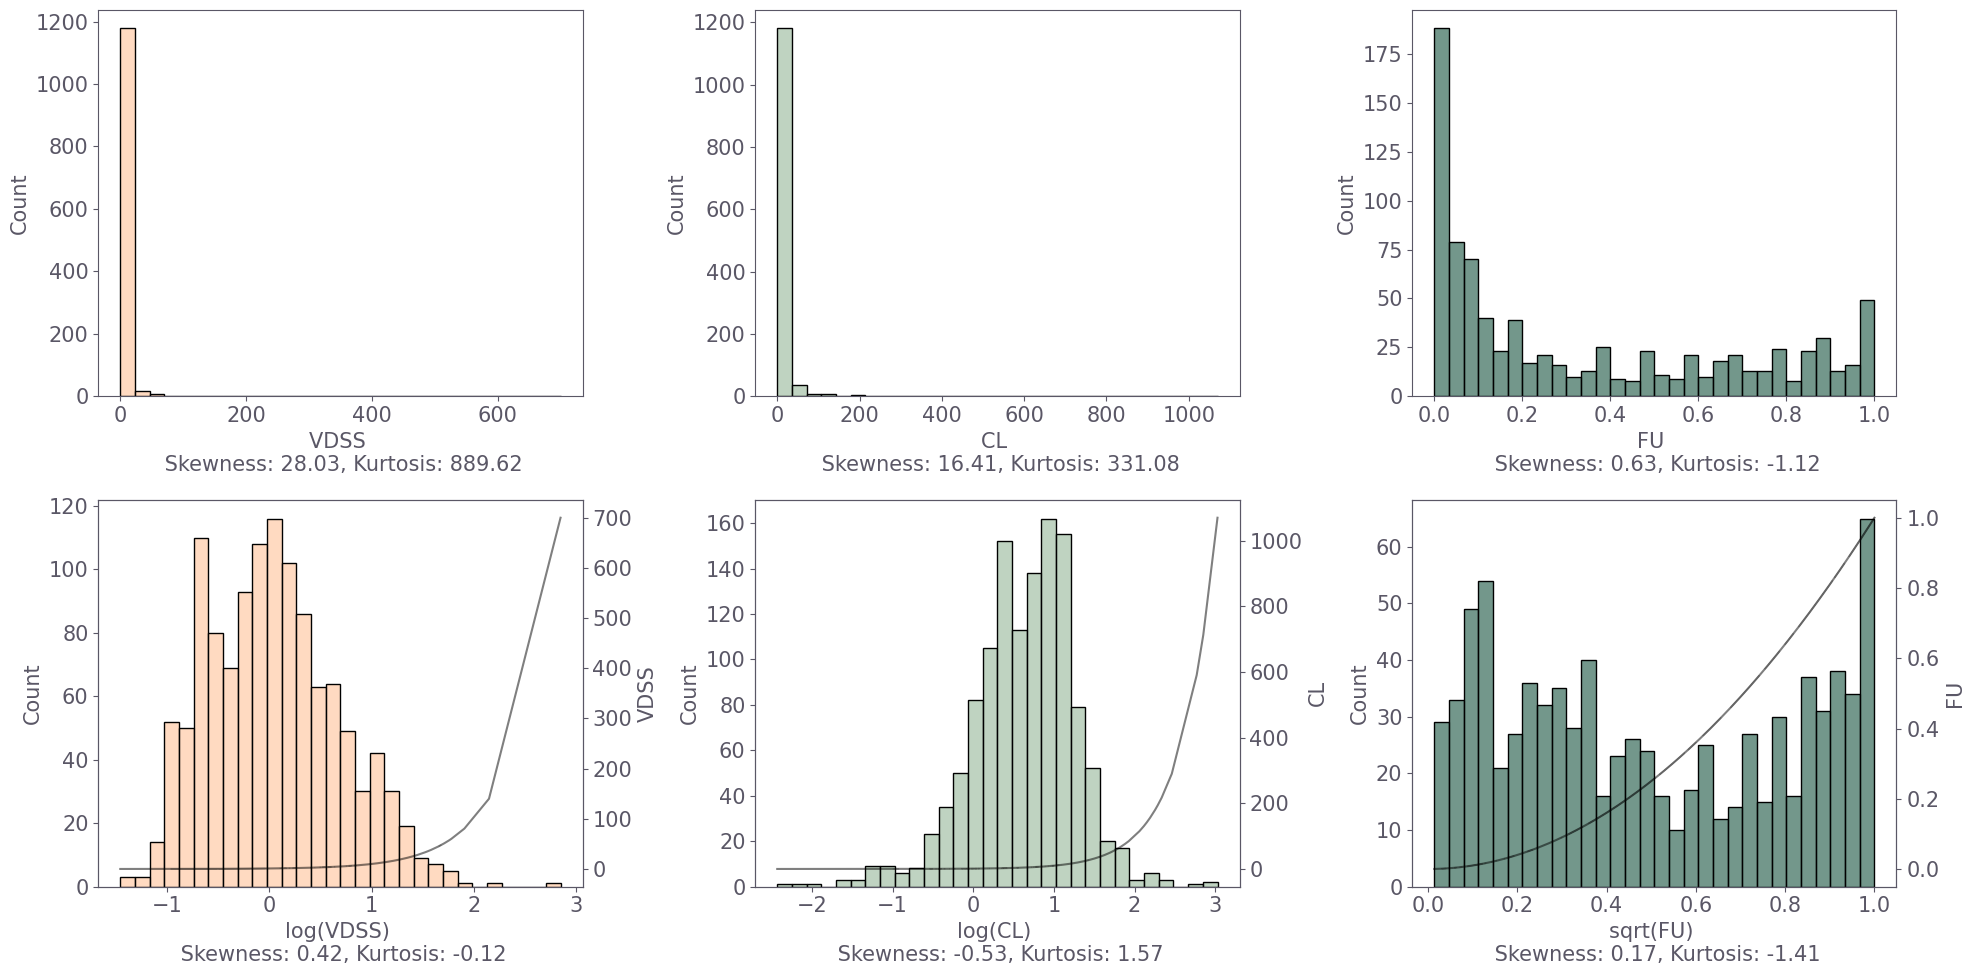

In [12]:
# Supplementary figure S2
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Plot each combination of column and transformation
plot_distribution(df, "VDSS", ax[0, 0], a2arcolors[0], None)
plot_distribution(df, "CL", ax[0, 1], a2arcolors[1], None)
plot_distribution(df, "FU", ax[0, 2], a2arcolors[2], None)
plot_distribution(df, "VDSS", ax[1, 0], a2arcolors[0], 'log')
plot_distribution(df, "CL", ax[1, 1], a2arcolors[1], 'log')
plot_distribution(df, "FU", ax[1, 2], a2arcolors[2], 'sqrt')

plt.tight_layout()
plt.savefig(join(PK_FIGURES_DIR, "PKDataset_Distribution_log_sqrt.png"), dpi=400)
plt.show()

# Physchiochemical properties of the dataset
This code creates Supplementary Figure S8 -
plots of the physicochemical properties of the dataset compounds for the highest and lowest 10th percentile of VDSS, CL and FU in the Lombardo et al.

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


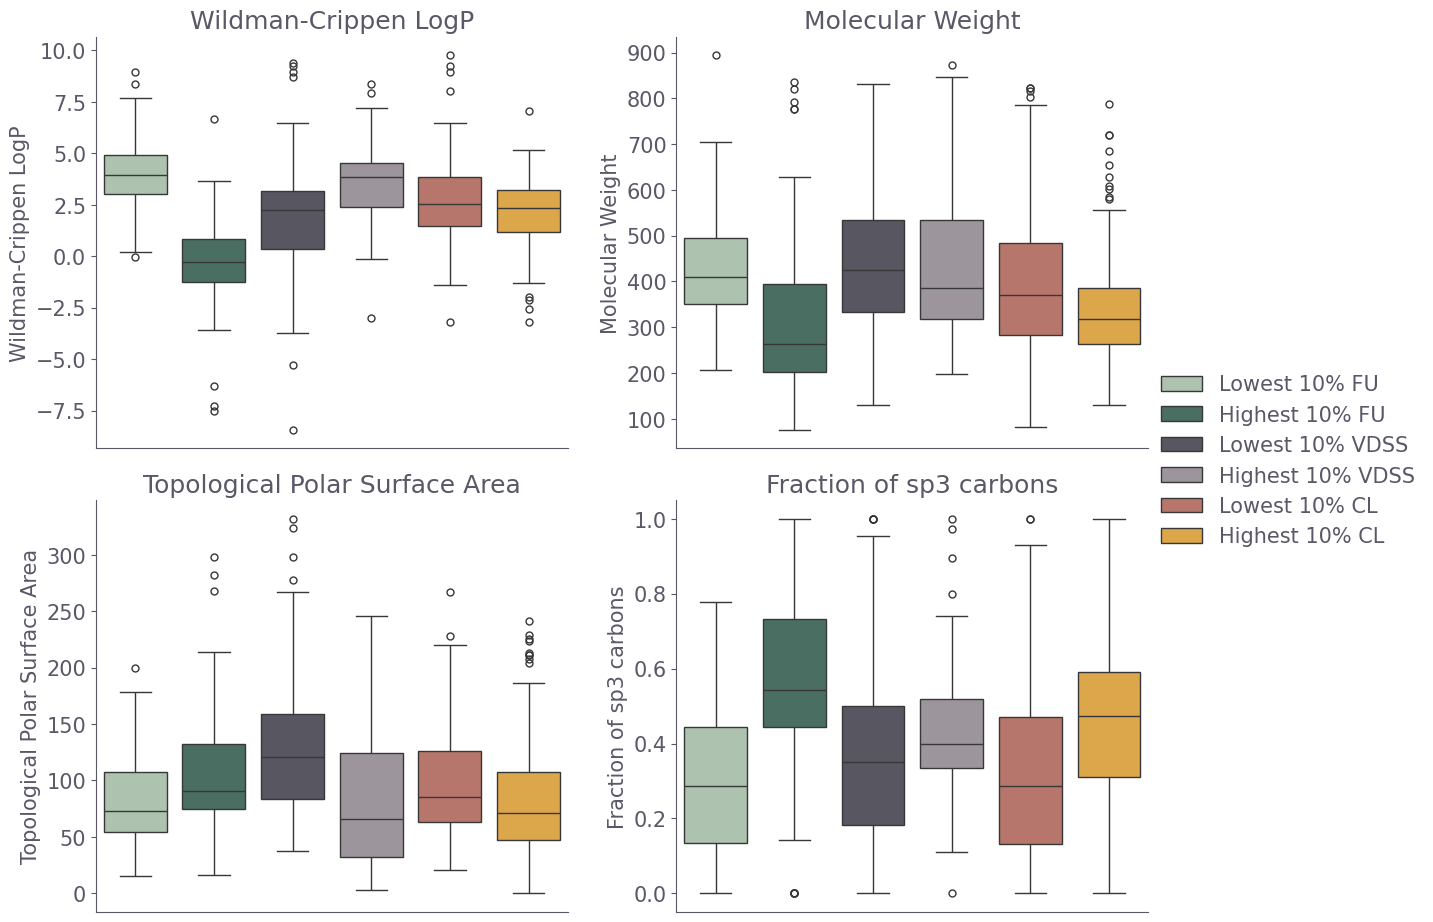

In [ ]:
# Supplementary figure S8
# Calculate physicochemical descriptors
moltable = MoleculeTable("PKDataset", df, n_jobs=4)
moltable.addDescriptors([RDKitDescs(["MolLogP", "MolWt", "TPSA", "FractionCSP3"])])
descriptors = moltable.getDescriptors()
df_physchem = pd.concat([df, descriptors], axis=1)

# Calculate 10th and 90th percentile for each descriptor
df_physchem = df_physchem[["CL", "VDSS", "FU", "MolLogP", "MolWt", "TPSA", "FractionCSP3"]]
df_bottom10_FU = df_physchem[df_physchem["FU"] < df_physchem["FU"].quantile(0.1)]
df_top10_FU = df_physchem[df_physchem["FU"] > df_physchem["FU"].quantile(0.9)]
df_bottom10_VDSS = df_physchem[df_physchem["VDSS"] < df_physchem["VDSS"].quantile(0.1)]
df_top10_VDSS = df_physchem[df_physchem["VDSS"] > df_physchem["VDSS"].quantile(0.9)]
df_bottom10_CL = df_physchem[df_physchem["CL"] < df_physchem["CL"].quantile(0.1)]
df_top10_CL = df_physchem[df_physchem["CL"] > df_physchem["CL"].quantile(0.9)]

df_physchem = pd.concat(
    [df_bottom10_FU,
     df_top10_FU,
     df_bottom10_VDSS,
     df_top10_VDSS,
     df_bottom10_CL,
     df_top10_CL
])
df_physchem["set"] = (
    ["Lowest 10% FU"] * len(df_bottom10_FU) + ["Highest 10% FU"] * len(df_top10_FU) +
    ["Lowest 10% VDSS"] * len(df_bottom10_VDSS) + ["Highest 10% VDSS"] * len(df_top10_VDSS) +
    ["Lowest 10% CL"] * len(df_bottom10_CL) + ["Highest 10% CL"] * len(df_top10_CL)
)

# Create boxplot of physicochemical descriptors
df_melted = df_physchem.melt(
    id_vars=["set"],
    value_vars=["MolLogP", "MolWt", "TPSA", "FractionCSP3"],
    var_name="Descriptor",
    value_name="value"
)
descriptor_dict = {
    "MolLogP": "Wildman-Crippen LogP",
    "MolWt": "Molecular Weight",
    "TPSA": "Topological Polar Surface Area",
    "FractionCSP3": "Fraction of sp3 carbons"
}
df_melted["Descriptor"] = df_melted["Descriptor"].replace(descriptor_dict)

g = sns.catplot(
    data=df_melted, x="set", y="value", hue="set", kind="box", col="Descriptor",
    col_wrap=2, sharey=False, legend=True, height=5, aspect=1.2,
    palette=a2arcolors[1:7])
g._legend.set_title("")
for ax in g.axes:
    ax.set_title(ax.get_title().split(" = ")[1])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel(ax.get_title())
plt.savefig(join(PK_FIGURES_DIR, "PKDataset_PhysChemDescriptors.png"), dpi=300)